In [2]:
# Який середній surcharge за годинами і днями тижня для поїздок з нестандартним тарифом (rate_code ≠ 0)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, avg, to_timestamp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:

spark = SparkSession.builder \
    .appName("AvgSurchargeByHourDay") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_data_cleaned.parquet")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 23:10:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/16 23:10:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/16 23:10:48 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/04/16 23:10:48 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/04/16 23:10:48 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/04/16 23:10:48 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [4]:
df = df_trip.join(
    df_fare,
    on=["medallion", "hack_license", "pickup_datetime"],
    how="inner"
)
df = df.withColumn("pickup_time", to_timestamp("pickup_datetime")) \
       .withColumn("hour", hour("pickup_time")) \
       .withColumn("day_of_week", dayofweek("pickup_time"))

df_filtered = df.filter(col("rate_code") != 0)

df_grouped = df_filtered.groupBy("day_of_week", "hour").agg(
    avg("surcharge").alias("avg_surcharge")
).orderBy("day_of_week", "hour")


In [5]:
pdf_result = df_grouped.toPandas()
weekday_map = {
    1: "Неділя", 2: "Понеділок", 3: "Вівторок", 4: "Середа",
    5: "Четвер", 6: "П’ятниця", 7: "Субота"
}
pdf_result["weekday_name"] = pdf_result["day_of_week"].map(weekday_map)
weekday_order = ["Понеділок", "Вівторок", "Середа", "Четвер", "П’ятниця", "Субота", "Неділя"]
pdf_result["weekday_name"] = pd.Categorical(pdf_result["weekday_name"], categories=weekday_order, ordered=True)

heatmap_data = pdf_result.pivot(index="weekday_name", columns="hour", values="avg_surcharge")

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=18686Kb max_used=18686Kb free=112385Kb
 bounds [0x00000001079f8000, 0x0000000108c58000, 0x000000010f9f8000]
 total_blobs=7821 nmethods=6861 adapters=873
 compilation: disabled (not enough contiguous free space left)


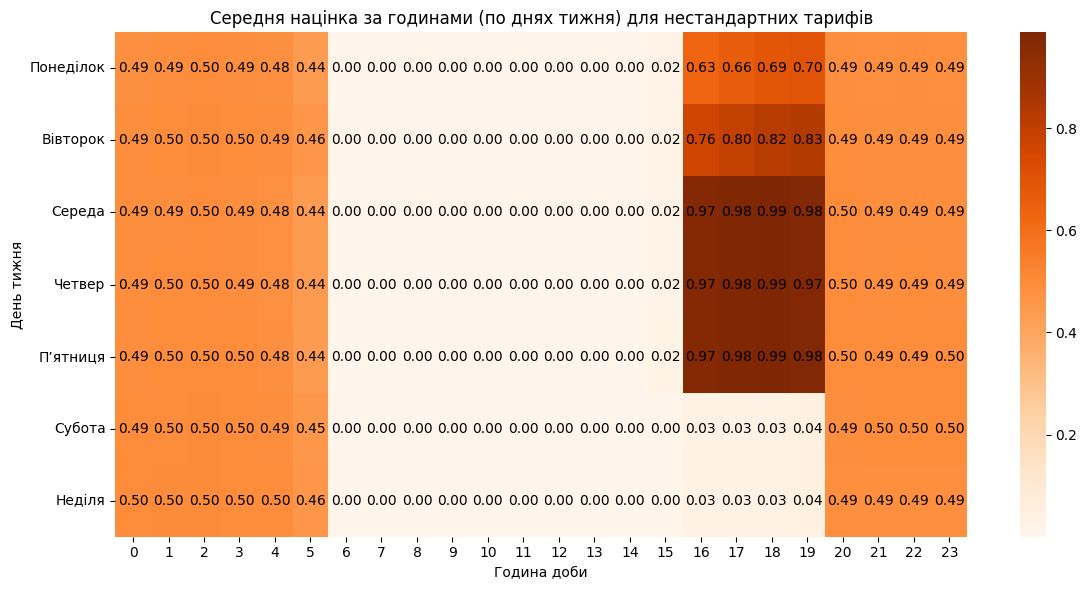

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Oranges", annot_kws={"color": "black"})
plt.title("Середня націнка за годинами (по днях тижня) для нестандартних тарифів")
plt.xlabel("Година доби")
plt.ylabel("День тижня")
plt.tight_layout()
plt.show()

In [7]:
df_grouped.write.option("header", True).mode("overwrite").csv("/Users/mac/Development/nyc-taxi-spark-project/results/1.csv")

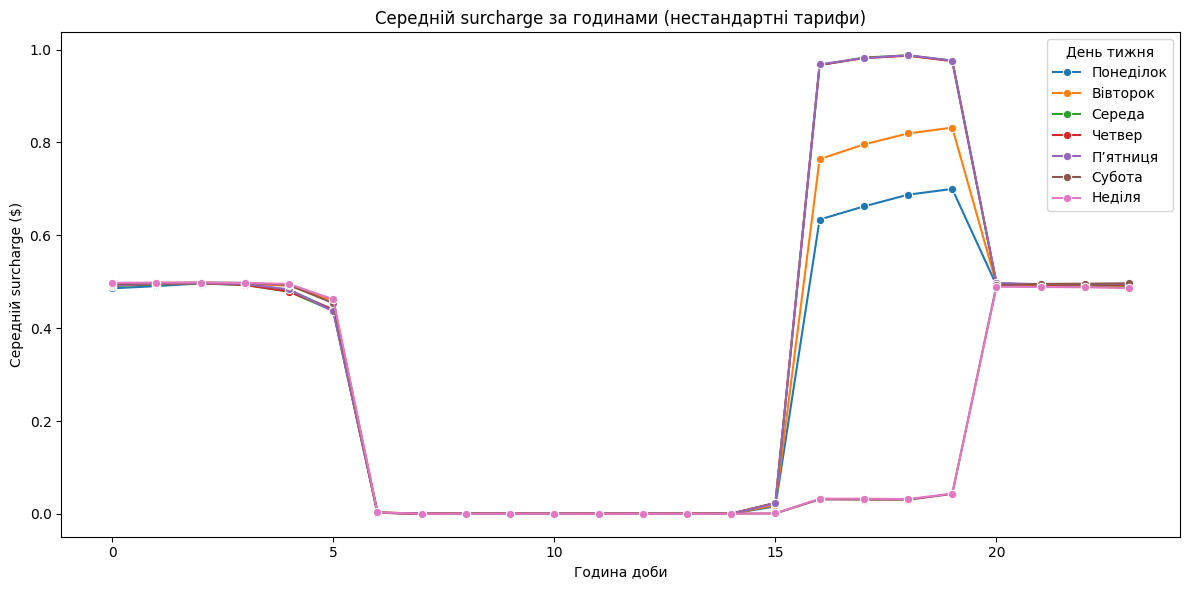

In [8]:
# Лінійний графік
plt.figure(figsize=(12, 6))
sns.lineplot(data=pdf_result, x="hour", y="avg_surcharge", hue="weekday_name", marker="o")
plt.title("Середній surcharge за годинами (нестандартні тарифи)")
plt.xlabel("Година доби")
plt.ylabel("Середній surcharge ($)")
plt.legend(title="День тижня")
plt.tight_layout()
plt.show()